<a href="https://colab.research.google.com/github/KamilBartosik/RNN_AirPolutionPrediction/blob/main/RNN_AirPolutionData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [42]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout

In [3]:
dataset_path = '/content/gdrive/MyDrive/MachineLearning/Datasets/Air_Pollution/Dataset.csv'
df = pd.read_csv(dataset_path)

# Data preprocessing

In [4]:
df.head()

,Date,Temperature,NOx,Wind Direction,Wind Speed,PM2.5
0,1/1/19 0:00,17.2,16.2,18,2,17
1,1/1/19 1:00,17.2,17,357,2.2,20
2,1/1/19 2:00,17.0,14.6,16,2.3,14
3,1/1/19 3:00,16.8,12.8,6,2.7,15
4,1/1/19 4:00,16.7,16.3,14,2.2,10


In [5]:
df.shape

(1416, 6)

In [6]:
df = df.iloc[:, 1:]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1416 entries, 0 to 1415
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature     1416 non-null   float64
 1   NOx             1416 non-null   object 
 2   Wind Direction  1416 non-null   object 
 3   Wind Speed      1416 non-null   object 
 4   PM2.5           1416 non-null   object 
dtypes: float64(1), object(4)
memory usage: 55.4+ KB


In [8]:
wrong_NOx = []
wrong_WD = []
wrong_WS = []
wrong_PM = []

def check_wrong_values(column, values):
  
  for i in range(len(df)):
    try:
      df.loc[i, column] = float(df.loc[i, column])
    except:
      values.append(i)

In [9]:
def display_examples(column, values, ex_11, ex_12, ex_21, ex_22):
  
  print('Wrong values:')
  print(df.loc[values, column])

  print('\nHow value(s) of 1st example look among neighbours:\n')
  print(df.loc[ex_11:ex_12, column])

  print('\nHow value(s) of 2nd example look among neighbours:\n')
  print(df.loc[ex_21:ex_22, column])

In [10]:
check_wrong_values('NOx', wrong_NOx)

In [11]:
display_examples('NOx', wrong_NOx, 157, 163, 1258, 1267)

Wrong values:
159     13.1#                          
161     23#                            
179     18.5#                          
272     49.9#                          
325     10.9#                          
491     26.2#                          
673     38.6#                          
951     11.2#                          
1261    9.1#                           
1263    8.5#                           
1264    12.4#                          
1335    50.1#                          
Name: NOx, dtype: object

How value(s) of 1st example look among neighbours:

157                               12.8
158                               13.0
159    13.1#                          
160                               16.1
161    23#                            
162                               21.6
163                               15.0
Name: NOx, dtype: object

How value(s) of 2nd example look among neighbours:

1258                               15.1
1259                               14

In [12]:
check_wrong_values('Wind Direction', wrong_WD)

In [13]:
display_examples('Wind Direction', wrong_WD, 417, 423, 1089, 1095)

Wrong values:
420     295#                           
1092    0#                             
Name: Wind Direction, dtype: object

How value(s) of 1st example look among neighbours:

417                              268.0
418                              344.0
419                              312.0
420    295#                           
421                              299.0
422                              301.0
423                              302.0
Name: Wind Direction, dtype: object

How value(s) of 2nd example look among neighbours:

1089                               17.0
1090                              338.0
1091                               31.0
1092    0#                             
1093                              284.0
1094                              221.0
1095                              256.0
Name: Wind Direction, dtype: object


In [14]:
check_wrong_values('Wind Speed', wrong_WS)

In [15]:
display_examples('Wind Speed', wrong_WS, 417, 423, 1089, 1095)

Wrong values:
420     1.6#                           
1092    0#                             
Name: Wind Speed, dtype: object

How value(s) of 1st example look among neighbours:

417                                1.4
418                                1.6
419                                2.1
420    1.6#                           
421                                2.5
422                                2.5
423                                2.5
Name: Wind Speed, dtype: object

How value(s) of 2nd example look among neighbours:

1089                                2.1
1090                                2.7
1091                                1.5
1092    0#                             
1093                                1.7
1094                                3.9
1095                                2.4
Name: Wind Speed, dtype: object


In [16]:
check_wrong_values('PM2.5', wrong_PM)

In [17]:
print('Wrong values:')
print(df.loc[wrong_PM, 'PM2.5'])

Wrong values:
37      16#                            
38      27#                            
159     793#                           
178     745#                           
323     27#                            
324     30#                            
420     1#                             
491     785#                           
492     33#                            
580     161*                           
581     157x                           
582     155x                           
606     98x                            
734     43#                            
735     27#                            
950     784#                           
1091    33#                            
1092    47#                            
1262    22#                            
1263    753#                           
1264    42#                            
1335    800#                           
1359    25#                            
1360    174#                           
1361    170#              

In [18]:
def replace_hashes(column, values):
  
  for i in values:
    df.loc[i, column] = df.loc[i, column].replace("#", "")

replace_hashes('NOx', wrong_NOx)
replace_hashes('Wind Direction', wrong_WD)
replace_hashes('Wind Speed', wrong_WS)

In [19]:
for i in wrong_PM:
  try:
    df.loc[i, 'PM2.5'] = int( (df.loc[i-1, 'PM2.5'] + df.loc[i+1, 'PM2.5']) / 2 )
  except:
    df.loc[i, 'PM2.5'] = int(df.loc[i-1, 'PM2.5'])

In [20]:
print(df.loc[wrong_PM, 'PM2.5'])

37      16
38      23
159     22
178     35
323     27
324     28
420     41
491     20
492     27
580     58
581     58
582     60
606     84
734     43
735     32
950     28
1091    33
1092    37
1262    22
1263    22
1264    24
1335    33
1359    25
1360    25
1361    25
1362    21
Name: PM2.5, dtype: object


In [21]:
df = df.astype({'NOx':'float', 'Wind Direction':'int', 'Wind Speed':'float', 'PM2.5':'int'})

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1416 entries, 0 to 1415
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature     1416 non-null   float64
 1   NOx             1416 non-null   float64
 2   Wind Direction  1416 non-null   int64  
 3   Wind Speed      1416 non-null   float64
 4   PM2.5           1416 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 55.4 KB


In [23]:
df.describe()

,Temperature,NOx,Wind Direction,Wind Speed,PM2.5
count,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000
mean,20.950282,19.421398,116.644774,2.450777,33.048729
std,3.438216,8.622356,141.731594,0.801641,17.385011
min,12.000000,5.700000,0.000000,0.000000,1.000000
25%,18.700000,13.600000,13.000000,1.900000,21.000000
50%,20.500000,17.300000,24.000000,2.500000,30.000000
75%,23.400000,23.000000,301.000000,3.000000,42.000000
max,30.500000,73.100000,360.000000,4.800000,108.000000


# Preparing data for training

## Creating train and test sets

In [24]:
train_set_size = 0.9
train_set_size = int( train_set_size*len(df) )

In [25]:
train_set = df.iloc[0:train_set_size, :]
test_set = df.iloc[train_set_size:, -1:].reset_index(drop=True)

In [26]:
train_set

,Temperature,NOx,Wind Direction,Wind Speed,PM2.5
0,17.2,16.2,18,2.0,17
1,17.2,17.0,357,2.2,20
2,17.0,14.6,16,2.3,14
3,16.8,12.8,6,2.7,15
4,16.7,16.3,14,2.2,10
...,...,...,...,...,...
1269,19.2,15.4,353,2.5,21
1270,18.9,18.1,358,2.8,28
1271,18.6,21.8,14,2.7,24
1272,18.4,20.9,5,3.1,23


In [27]:
test_set

,PM2.5
0,11
1,9
2,10
3,15
4,20
...,...
137,26
138,23
139,24
140,26


## Feature Scaling

In [28]:
# Scaler for training
sc = MinMaxScaler(feature_range=(0, 1))
train_set_scaled = sc.fit_transform(train_set)

# Scaler for prediction
sc_predict = MinMaxScaler(feature_range=(0, 1))
sc_predict.fit_transform(train_set.iloc[:, -1:])

array([[0.14953271],
       [0.17757009],
       [0.12149533],
       ...,
       [0.21495327],
       [0.20560748],
       [0.13084112]])

## Creating data structure with n timesteps

In [29]:
n = 96

X_train = []
y_train = []

for i in range(n, len(train_set)):
  X_train.append(train_set_scaled[ i-n:i, :])
  y_train.append(train_set_scaled[ i, -1 ])

X_train, y_train = np.array(X_train), np.array(y_train)

In [30]:
X_train.shape

(1178, 96, 5)

# RNN architecture

In [31]:
def myRNN(model_name, optimizer, nb_epochs, batch_size):

  regressor = Sequential()

  if model_name == "LSTM":
    
    regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    regressor.add(Dropout(0.2))

    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))

    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))

    regressor.add(LSTM(units = 50))
    regressor.add(Dropout(0.2))

  elif model_name == "GRU":
    
    regressor.add(GRU(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    regressor.add(Dropout(0.2))

    regressor.add(GRU(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))

    regressor.add(GRU(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))

    regressor.add(GRU(units = 50))
    regressor.add(Dropout(0.2))

  else:
    raise ValueError("Error: Wrong model name! Possible options: 'LSTM' or 'GRU'")

  regressor.add(Dense(units = 1))
  regressor.compile(optimizer = optimizer, loss = 'mean_squared_error')
  training = regressor.fit(X_train, y_train, epochs = nb_epochs, batch_size = batch_size)

  return regressor, training

# Prediction

## Input for prediction

In [32]:
test_inputs = df[train_set_size - n:]
test_inputs = sc.transform(test_inputs)

In [33]:
test_inputs.shape

(238, 5)

In [34]:
X_test = []

for i in range(n, len(test_inputs)):
  X_test.append(test_inputs[ i-n:i, : ])

X_test = np.array(X_test)

In [35]:
X_test.shape

(142, 96, 5)

## Prediction function

In [36]:
def make_predictions(model, name):
  
  predicted_PM25 = model.predict(X_test)
  predicted_PM25 = sc_predict.inverse_transform(predicted_PM25)

  return predicted_PM25

In [37]:
def calculate_metrics(predictions):
  
  rmse = math.sqrt(mean_squared_error(test_set, predictions))
  r2 = r2_score(test_set, predictions)
  adj_r2 = 1 - (1 - r2)*(len(test_set) - 1)/(len(test_set) - X_test.shape[1] - 1)

  return rmse, r2, adj_r2

In [38]:
def display_results(name, rmse, r2, adj_r2):

  print(f"Metrics for {name} model:\n\n\tRMSE: {' '*7}{rmse}\n\tR2: {' '*9}{r2}\n\tAdjusted R2: {adj_r2}")

## Visualisation function

In [39]:
def make_plots(model_training, predictions, name):
  
  plt.plot(model_training.history['loss'], color = 'blue')
  plt.title(f'{name} model training')
  plt.xlabel('Epoch')
  plt.ylabel('MSE loss')
  plt.show()

  plt.plot(test_set, color = 'black', label = 'Real PM 2.5')
  plt.plot(predictions, color = 'red', label = 'Predicted PM 2.5')
  plt.title(f'PM 2.5 Prediction with {name}')
  plt.xlabel('Time [hours]')
  plt.ylabel('PM 2.5')
  plt.legend()
  plt.show()

# Execute RNN training and results

In [40]:
model_lstm, training_lstm = myRNN("LSTM", "RMSProp", 100, 32)

Epoch 1/100
37/37 [==============================] - 15s 189ms/step - loss: 0.0345
Epoch 2/100
37/37 [==============================] - 7s 188ms/step - loss: 0.0234
Epoch 3/100
37/37 [==============================] - 7s 186ms/step - loss: 0.0200
Epoch 4/100
37/37 [==============================] - 7s 202ms/step - loss: 0.0183
Epoch 5/100
37/37 [==============================] - 7s 189ms/step - loss: 0.0174
Epoch 6/100
37/37 [==============================] - 7s 191ms/step - loss: 0.0157
Epoch 7/100
37/37 [==============================] - 7s 191ms/step - loss: 0.0147
Epoch 8/100
37/37 [==============================] - 7s 192ms/step - loss: 0.0142
Epoch 9/100
37/37 [==============================] - 7s 191ms/step - loss: 0.0132
Epoch 10/100
37/37 [==============================] - 7s 190ms/step - loss: 0.0125
Epoch 11/100
37/37 [==============================] - 7s 189ms/step - loss: 0.0114
Epoch 12/100
37/37 [==============================] - 7s 192ms/step - loss: 0.0117
Epoch 13/100

In [41]:
model_gru, training_gru = myRNN("GRU", "RMSProp", 100, 32)

Epoch 1/100
37/37 [==============================] - 14s 187ms/step - loss: 0.0266
Epoch 2/100
37/37 [==============================] - 7s 186ms/step - loss: 0.0158
Epoch 3/100
37/37 [==============================] - 7s 186ms/step - loss: 0.0133
Epoch 4/100
37/37 [==============================] - 7s 193ms/step - loss: 0.0130
Epoch 5/100
37/37 [==============================] - 7s 186ms/step - loss: 0.0117
Epoch 6/100
37/37 [==============================] - 7s 194ms/step - loss: 0.0112
Epoch 7/100
37/37 [==============================] - 7s 188ms/step - loss: 0.0091
Epoch 8/100
37/37 [==============================] - 7s 186ms/step - loss: 0.0093
Epoch 9/100
37/37 [==============================] - 7s 185ms/step - loss: 0.0087
Epoch 10/100
37/37 [==============================] - 8s 213ms/step - loss: 0.0080
Epoch 11/100
37/37 [==============================] - 8s 209ms/step - loss: 0.0073
Epoch 12/100
37/37 [==============================] - 7s 192ms/step - loss: 0.0076
Epoch 13/100

In [43]:
predictions_lstm = make_predictions(model_lstm, "LSTM")
predictions_gru = make_predictions(model_gru, "GRU")

In [44]:
rmse_lstm, r2_lstm, adj_r2_lstm = calculate_metrics(predictions_lstm)
rmse_gru, r2_gru, adj_r2_gru = calculate_metrics(predictions_gru)

In [45]:
display_results("LSTM", rmse_lstm, r2_lstm, adj_r2_lstm)
print("")
display_results("GRU", rmse_gru, r2_gru, adj_r2_gru)

Metrics for LSTM model:

	RMSE:        5.78302098250731
	R2:          0.835048399303995
	Adjusted R2: 0.48315165115251757

Metrics for GRU model:

	RMSE:        5.597931028983302
	R2:          0.8454382291859812
	Adjusted R2: 0.5157064514494079


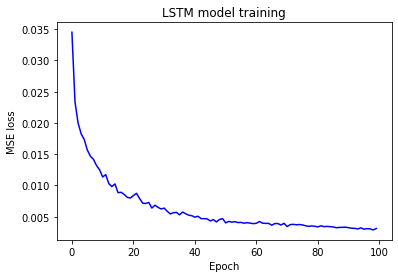

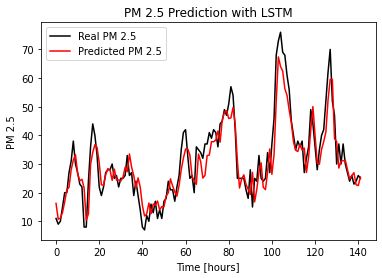

In [46]:
make_plots(training_lstm, predictions_lstm, "LSTM")

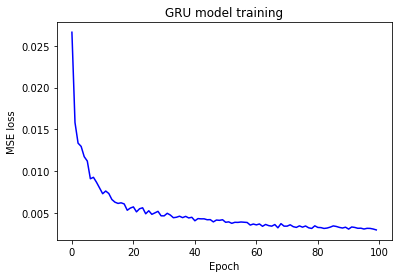

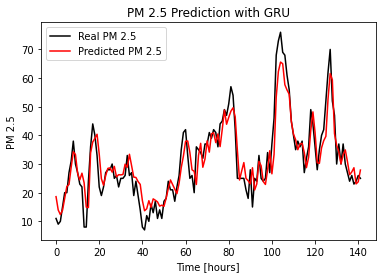

In [47]:
make_plots(training_gru, predictions_gru, "GRU")